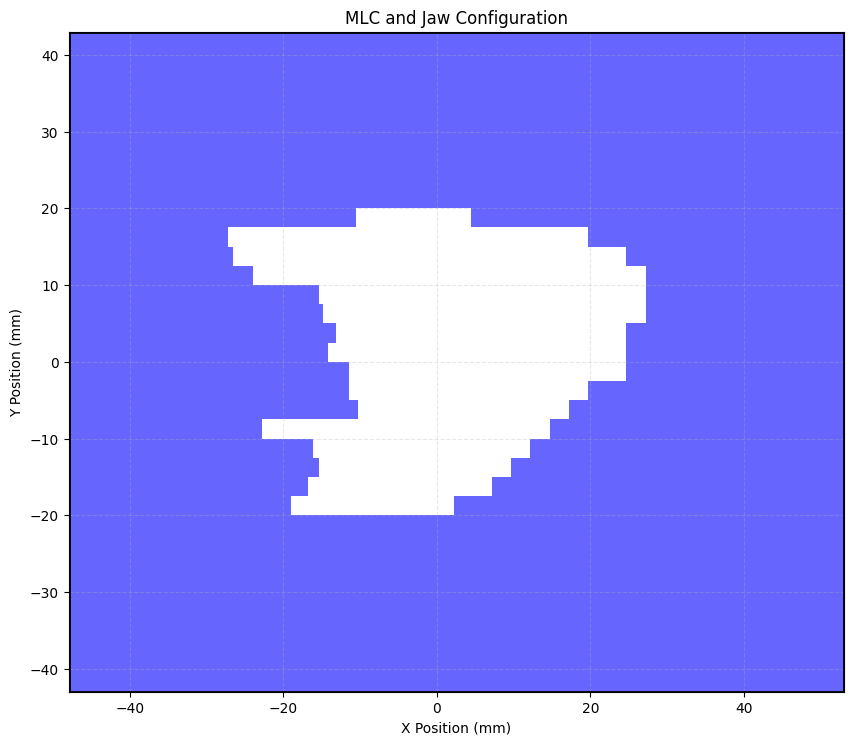

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# file = "1. prostate_imrt_beam0_cp0.dat"
file = "new/prostate_imrt_beam0_cp74.dat"
leaf_height = 2.5 # mm

def parse_mlc_data():
  with open(file) as fp:
    data = fp.read()
  lines = data.strip().split('\n')
  
  # read data from comments
  comments = [line for line in lines if line.startswith('#')]
  comment_params = {}
  for comment in comments:
    key = comment.removeprefix("# ").rstrip("0123456789. :")
    value = comment.removeprefix('# ').split(" ", 1)[1]
    if '.' in value:
      try:
        value = float(value)
      except ValueError:
        continue
    else:
      try:
        value = int(value)
      except ValueError:
        continue
    comment_params[key] = value
  
  # remove comments, no longer needed
  lines = [line for line in lines if not line.startswith("#")]
  
  # Parse jaws data
  jaws = map(float, lines[0].split(','))
  
  # Parse MLC positions
  mlc_positions = []
  for line in lines[1:]:
    if ',' in line:
      left, right = map(float, line.split(','))
      mlc_positions.append((left, right))
  
  return jaws, np.array(mlc_positions), comment_params

def plot_mlc_configuration():
  """
  X1,X2,Y1,Y2 - służą tylko do limitowania plotu
  len(mlc_positions) - wyznacza Faktyczną przestrzeń plotu danych w Y 
  (miałem do wyboru 64 z prezentacji vs 60 z tego pliku, biorę len(mlc) == 60)
  """
  # Parse data
  (X1, X2, Y1, Y2), mlc_positions, comment_params = parse_mlc_data()
  
  # Create figure
  plt.figure(figsize=(10, 10))
  ax = plt.gca()
  
  # Calculate leaf heights
  n_leaves = len(mlc_positions)
  leaf_heights = np.arange(-n_leaves*leaf_height/2, (n_leaves*leaf_height+1)/2, leaf_height)
  
  # Plot each MLC leaf pair
  # data is arranged bottom-up
  for i, (left, right) in enumerate(mlc_positions):
    y_pos = leaf_heights[i]

    # plot rectangles

    # (X1, y_pos + leaf_height)-----(left, ypos + leaf_height)
    # |                                       |
    # (X1, y_pos)-------------------(left, y_pos)
    plt.fill([X1, left, left, X1],
              [y_pos, y_pos, y_pos + leaf_height, y_pos + leaf_height],
              'blue', alpha=0.6)
    
    # (right, y_pos + leaf_height)-----(X2, ypos + leaf_height)
    # |                                       |
    # (right, y_pos)-------------------(X2, y_pos)
    plt.fill([right, X2, X2, right],
              [y_pos, y_pos, y_pos + leaf_height, y_pos + leaf_height],
              'blue', alpha=0.6)
  
  # Plot jaw boundaries
  plt.plot([X1, X1], [Y1, Y2], 'k-', linewidth=2)  # Left jaw
  plt.plot([X2, X2], [Y1, Y2], 'k-', linewidth=2)  # Right jaw
  plt.plot([X1, X2], [Y1, Y1], 'k-', linewidth=2)  # Bottom jaw
  plt.plot([X1, X2], [Y2, Y2], 'k-', linewidth=2)  # Top jaw
  
  # Set plot properties
  plt.grid(True, linestyle='--', alpha=0.3)
  plt.xlabel('Y Position (mm)')
  plt.ylabel('X Position (mm)')
  plt.title('MLC and Jaw Configuration')
  
  # Set equal aspect ratio and limits
  ax.set_aspect('equal')
  # plt.xlim(X1 - 5, X2 + 5)
  # plt.ylim(Y1 - 5, Y2 + 5)
  plt.xlim(X1, X2)
  plt.ylim(Y1, Y2)
  
  return plt.gcf()

# Create and display the plot
fig = plot_mlc_configuration()
plt.show()

    Cell IdX  Cell IdY  Cell IdZ  X [mm]  Y [mm]  Z [mm]  Dose [Gy]  \
18         0         0         0     -18     -18       6   0.001323   
25         0         0         1     -18     -18      18   0.001751   
31         0         1         0     -18      -6       6   0.001229   
0          0         1         1     -18      -6      18   0.001558   
17         0         2         0     -18       6       6   0.000984   
14         0         2         1     -18       6      18   0.001343   
23         0         3         0     -18      18       6   0.001887   
30         0         3         1     -18      18      18   0.002364   
10         1         0         0      -6     -18       6   0.002973   
2          1         0         1      -6     -18      18   0.003730   
7          1         1         0      -6      -6       6   0.004030   
24         1         1         1      -6      -6      18   0.004958   
29         1         2         0      -6       6       6   0.004097   
11    

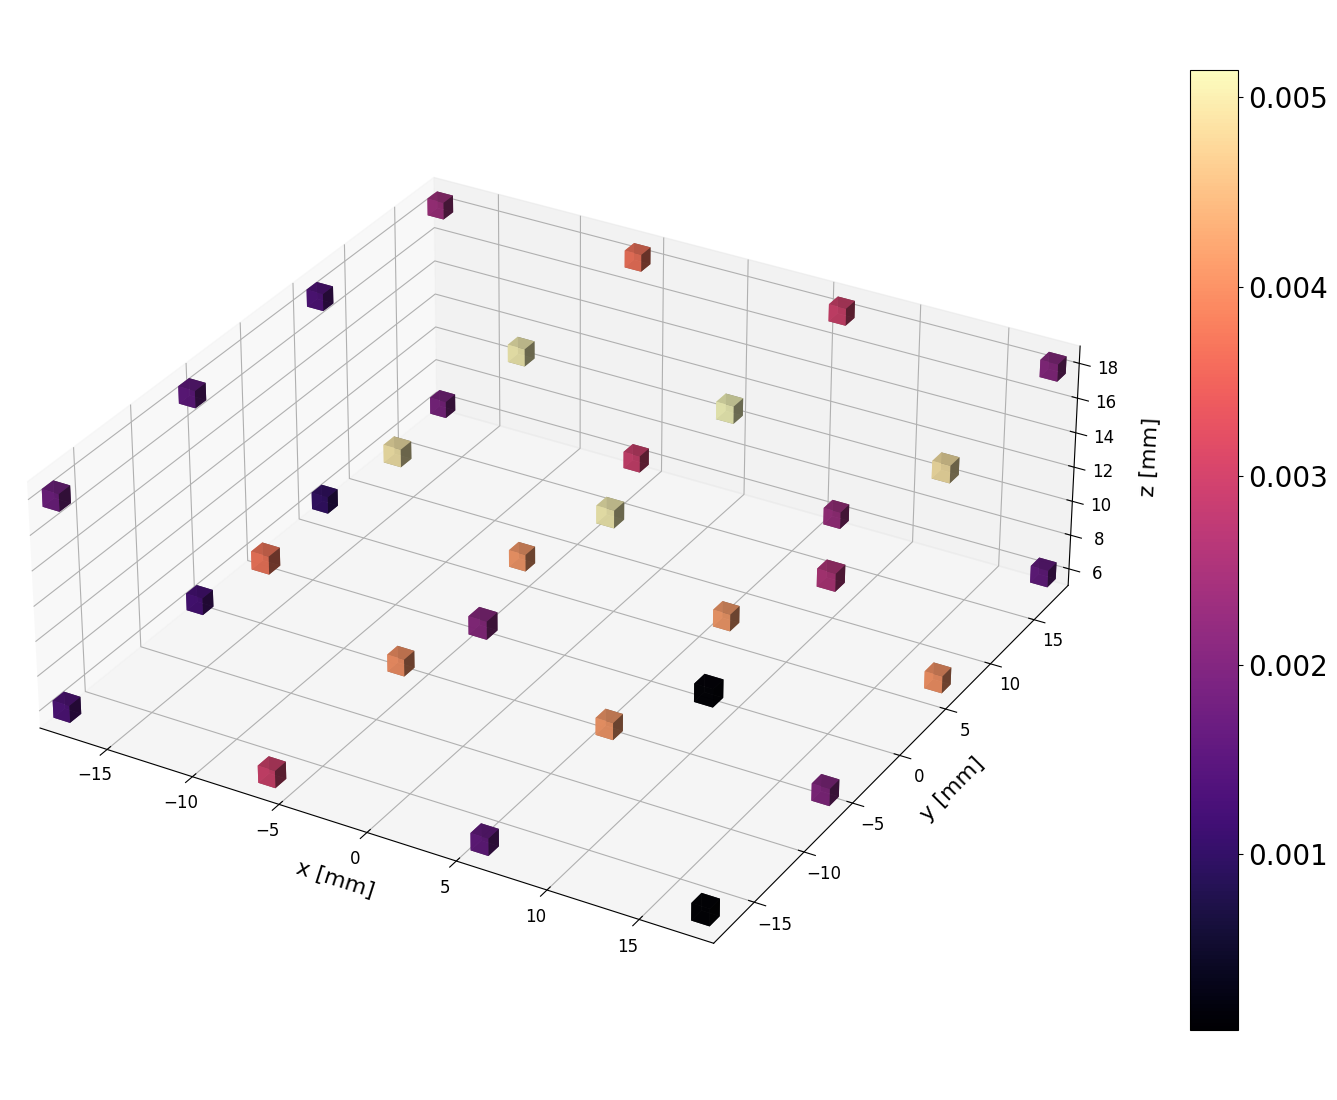

In [6]:
import pandas as pd
import polars as pl
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

phantom_counts_cmap = cm.magma

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

counter=0

def add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, min, max):
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

  global counter
  print(f"adding {counter} voxel...")
  counter+=1
  
  # phantom_counts_norm = colors.LogNorm(vmin=min, vmax=max)
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)


if __name__ == "__main__":
  # filename = "cp-0_d3ddetector_cell.csv"
  filename = "new/prostate_imrt_beam0_cp74_d3ddetector_cell.csv"
  raw_df = pd.read_csv(filename)

  sorted_df = raw_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
  voxel_side_len = 0.985
  observable = "Dose [Gy]"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')
  
  df = sorted_df
  print(df)

  dose_max = df[observable].max()
  dose_min = df[df[observable]>0][observable].min()
  
  for _, row in df.iterrows():
    if row[observable] == 0:
      print(f"skipping row {row}")
      continue
    x_center = row['X [mm]']
    y_center = row['Y [mm]']
    z_center = row['Z [mm]']

    dose = row[observable]
    add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, dose_min, dose_max)

  # Ustawienie limitów osi
  x_min, x_max = df['X [mm]'].min() - voxel_side_len, df['X [mm]'].max() + voxel_side_len
  y_min, y_max = df['Y [mm]'].min() - voxel_side_len, df['Y [mm]'].max() + voxel_side_len
  z_min, z_max = df['Z [mm]'].min() - voxel_side_len, df['Z [mm]'].max() + voxel_side_len

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()


iterating over input...
filling 64x64x64 space...
x = -31.5
x = -30.5
x = -29.5
x = -28.5
x = -27.5
x = -26.5
x = -25.5
x = -24.5
x = -23.5
x = -22.5
x = -21.5
x = -20.5
x = -19.5
x = -18.5
x = -17.5
x = -16.5
x = -15.5
x = -14.5
x = -13.5
x = -12.5
x = -11.5
x = -10.5
x = -9.5
x = -8.5
x = -7.5
x = -6.5
x = -5.5
x = -4.5
x = -3.5
x = -2.5
x = -1.5
x = -0.5
x = 0.5
x = 1.5
x = 2.5
x = 3.5
x = 4.5
x = 5.5
x = 6.5
x = 7.5
x = 8.5
x = 9.5
x = 10.5
x = 11.5
x = 12.5
x = 13.5
x = 14.5
x = 15.5
x = 16.5
x = 17.5
x = 18.5
x = 19.5
x = 20.5
x = 21.5
x = 22.5
x = 23.5
x = 24.5
x = 25.5
x = 26.5
x = 27.5
x = 28.5
x = 29.5
x = 30.5
x = 31.5
renormalizing fsf...
adding 1/32000 voxel...
adding 2/32000 voxel...
adding 3/32000 voxel...
adding 4/32000 voxel...
adding 5/32000 voxel...
adding 6/32000 voxel...
adding 7/32000 voxel...
adding 8/32000 voxel...
adding 9/32000 voxel...
adding 10/32000 voxel...
adding 11/32000 voxel...
adding 12/32000 voxel...
adding 13/32000 voxel...
adding 14/32000 voxel...


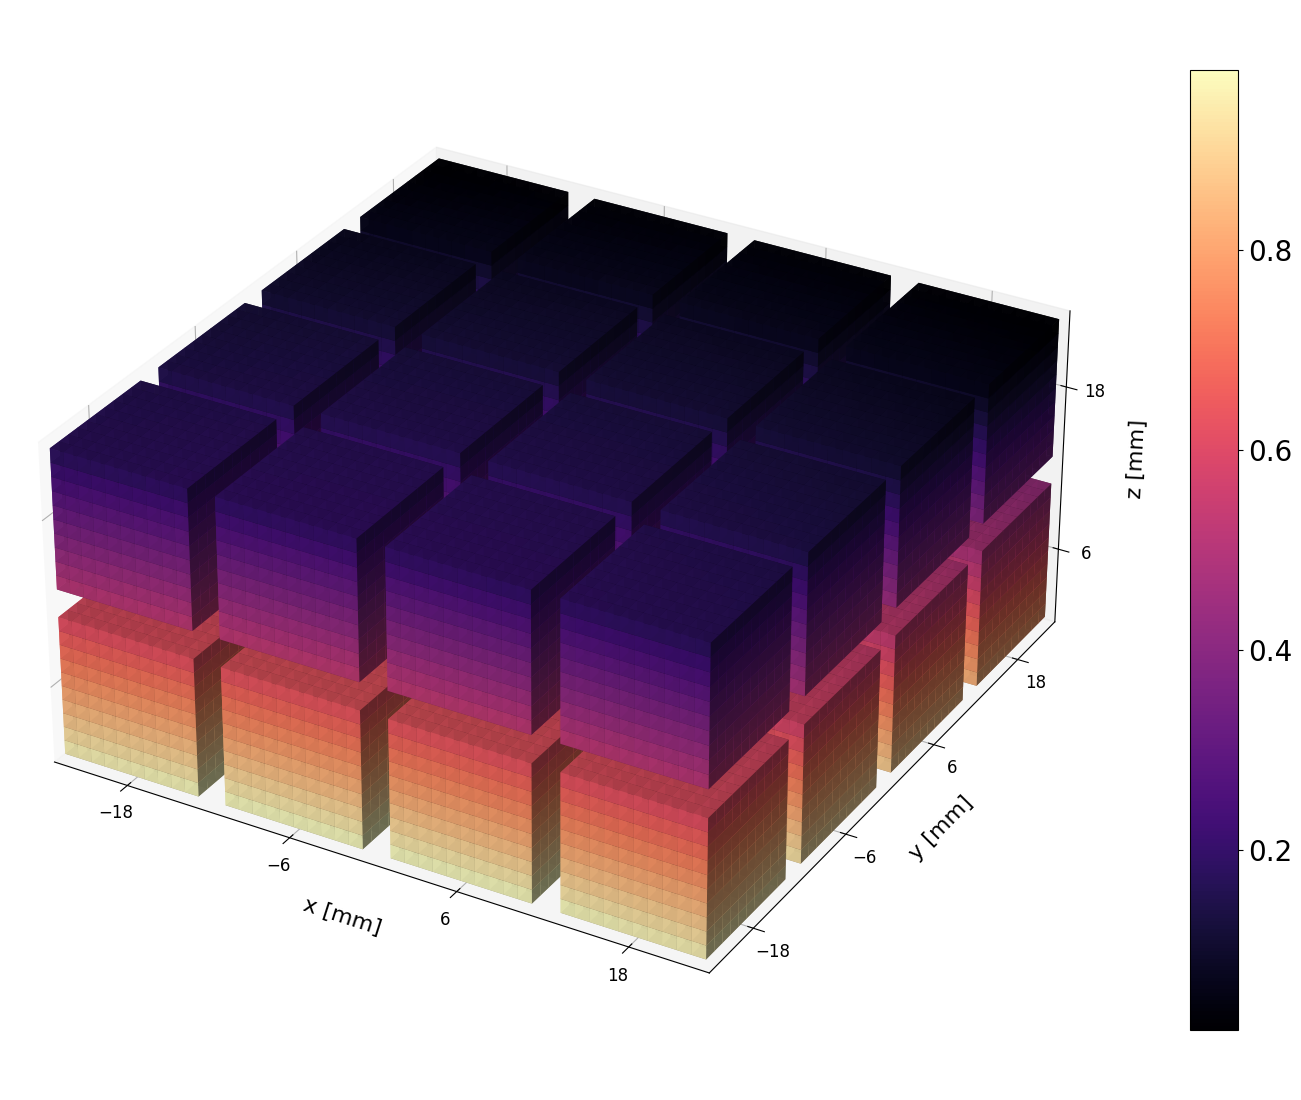

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.axes import Axes

phantom_counts_cmap = cm.magma

import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple, Union

## MLC ##

def parse_mlc_data(filename: str) -> Tuple[np.ndarray, np.ndarray, dict[str, Union[float, int]]]:
  with open(filename) as fp:
    data = fp.read()
  lines = data.strip().split('\n')
  
  # read data from comments
  comments = [line for line in lines if line.startswith('#')]
  comment_params = {}
  for comment in comments:
    key = comment.removeprefix("# ").rstrip("0123456789. :")
    value = comment.removeprefix('# ').split(" ", 1)[1]
    if '.' in value:
      try:
        value = float(value)
      except ValueError:
        continue
    else:
      try:
        value = int(value)
      except ValueError:
        continue
    comment_params[key] = value
  
  # remove comments, no longer needed
  lines = [line for line in lines if not line.startswith("#")]
  
  # Parse jaws data
  jaws = np.array(list(map(float, lines[0].split(','))))
  
  # Parse MLC positions
  mlc_positions = []
  for line in lines[1:]:
    if ',' in line:
      left, right = map(float, line.split(','))
      mlc_positions.append((left, right))
  
  return jaws, np.array(mlc_positions), comment_params

## OUTPUT GENERATION ##

def enrich_df(input_df: pd.DataFrame, jaws: np.ndarray, mlc_positions: np.ndarray, target_resolution: int=1, cell_size: int=10) -> pd.DataFrame:
  # otherwise "air" will "stick out" of grid 
  assert (cell_size//target_resolution) % 2 == 0, f"cell_size // target_resolution must be even, but is {cell_size//target_resolution}"

  unique_input_xs = sorted(input_df['X [mm]'].unique())
  unique_input_ys = sorted(input_df['Y [mm]'].unique())
  unique_input_zs = sorted(input_df['Z [mm]'].unique())

  voxel_no_per_cell = int(cell_size//target_resolution)
  cell_no_x = len(unique_input_xs)
  cell_no_y = len(unique_input_ys)
  cell_no_z = len(unique_input_zs)

  patient_cell_material = 0.28947
  air = 0.0211788

  # assuming cube space
  total_space_len = 64 # mm
  space_x_range = (-total_space_len+total_space_len//2, total_space_len-total_space_len//2)
  space_y_range = (-total_space_len+total_space_len//2, total_space_len-total_space_len//2)
  space_z_range = (-total_space_len+total_space_len//2, total_space_len-total_space_len//2)

  print("iterating over input...")
  filled_points = []

  # initial values are out of range, for correct min/max calculation
  min_voxel_x =  total_space_len
  max_voxel_x = -total_space_len
  min_voxel_y =  total_space_len
  max_voxel_y = -total_space_len
  min_voxel_z =  total_space_len
  max_voxel_z = -total_space_len
  
  for _, row in input_df.iterrows():
    # remember parameters from current row
    cell_idx = row["Cell IdX"]
    cell_idy = row["Cell IdY"]
    cell_idz = row["Cell IdZ"]
    dose = row["Dose [Gy]"]

    # generate new coord ranges for voxel entries
    filled_xs = np.linspace(
      row["X [mm]"] - cell_size/2 + target_resolution/2, 
      row["X [mm]"] + cell_size/2 - target_resolution/2, 
      voxel_no_per_cell
    )
    filled_ys = np.linspace(
      row["Y [mm]"] - cell_size/2 + target_resolution/2, 
      row["Y [mm]"] + cell_size/2 - target_resolution/2, 
      voxel_no_per_cell
      )
    filled_zs = np.linspace(
      row["Z [mm]"] - cell_size/2 + target_resolution/2, 
      row["Z [mm]"] + cell_size/2 - target_resolution/2, 
      voxel_no_per_cell
    )
    for voxel_idx, x in enumerate(filled_xs):
      for voxel_idy, y in enumerate(filled_ys):
        for voxel_idz, z in enumerate(filled_zs):
          filled_points.append({
            "x": x, 
            "y": y, 
            "z": z, 
            "cell_idx": int(cell_idx), 
            "cell_idy": int(cell_idy), 
            "cell_idz": int(cell_idz), 
            "voxel_idx": voxel_idx, 
            "voxel_idy": voxel_idy, 
            "voxel_idz": voxel_idz, 
            "dose": dose
          })
          # update voxel ranges
          min_voxel_x = min(min_voxel_x, x)
          max_voxel_x = max(max_voxel_x, x)
          min_voxel_y = min(min_voxel_y, y)
          max_voxel_y = max(max_voxel_y, y)
          min_voxel_z = min(min_voxel_z, z)
          max_voxel_z = max(max_voxel_z, z)
  
  print(f"filling {total_space_len}x{total_space_len}x{total_space_len} space...")
  raw_output = []
  x_iterstart = space_x_range[0] + target_resolution/2
  x_iterend   = space_x_range[1] - target_resolution/2 + 1
  y_iterstart = space_y_range[0] + target_resolution/2
  y_iterend   = space_y_range[1] - target_resolution/2 + 1
  z_iterstart = space_z_range[0] + target_resolution/2
  z_iterend   = space_z_range[1] - target_resolution/2 + 1
  for x in np.arange(x_iterstart, x_iterend, target_resolution):
    print(f"x = {x}")
    for y in np.arange(y_iterstart, y_iterend, target_resolution):
      for z in np.arange(z_iterstart, z_iterend, target_resolution):
        # filter out points outside voxel ranges
        if x < min_voxel_x or x > max_voxel_x or \
           y < min_voxel_y or y > max_voxel_y or \
           z < min_voxel_z or z > max_voxel_z:
          # "air" case
          raw_output.append({
            "Cell IdX": -1,
            "Cell IdY": -1,
            "Cell IdZ": -1,
            "Voxel IdX": -1,
            "Voxel IdY": -1,
            "Voxel IdZ": -1,
            "X [mm]": x,
            "Y [mm]": y,
            "Z [mm]": z,
            "Material": air,
            "Dose": 0,
            "FieldScalingFactor": 0
          })
          continue
        # check if current coords match any entry in filled points
        for index, entry in enumerate(filled_points):
          if x == entry['x'] and y == entry['y'] and z == entry['z']:
            break
        else:
          index = -1
        if index != -1:
          # coords match entry, "detector" case
          raw_output.append({
            "Cell IdX": filled_points[index]["cell_idx"],
            "Cell IdY": filled_points[index]["cell_idy"],
            "Cell IdZ": filled_points[index]["cell_idz"],
            "Voxel IdX": filled_points[index]["voxel_idx"],
            "Voxel IdY": filled_points[index]["voxel_idy"],
            "Voxel IdZ": filled_points[index]["voxel_idz"],
            "X [mm]": x,
            "Y [mm]": y,
            "Z [mm]": z,
            "Material": patient_cell_material,
            "Dose": filled_points[index]["dose"],
            "FieldScalingFactor": calculate_fsf(x, y, z, cell_no_x, cell_no_y, cell_no_z, jaws, mlc_positions)
          })
          # for speedup, delete for multiprocessing code
          del filled_points[index]
        else:
          # coords do not match entry, "air" case
          raw_output.append({
            "Cell IdX": -1,
            "Cell IdY": -1,
            "Cell IdZ": -1,
            "Voxel IdX": -1,
            "Voxel IdY": -1,
            "Voxel IdZ": -1,
            "X [mm]": x,
            "Y [mm]": y,
            "Z [mm]": z,
            "Material": air,
            "Dose": 0,
            "FieldScalingFactor": 0
          })
  output = pd.DataFrame(raw_output)
  # renormalize 
  renormalized_output = renormalize_fsf(output)

  return renormalized_output

## FSF ##

max_fsf_scaling = 0.98
min_fsf_scaling = 0.02

def calculate_fsf(x: np.float64, y: np.float64, z: np.float64, nx: int, ny: int, nz: int, jaws: np.ndarray, mlc_positions: np.ndarray) -> np.float64:
  """
  Assumptions: 
  - MLC_leaf positions are calculated as (x_leaf, y_leaf+leaf_height/2, mlc_detector_distance) V
  - angles are calculated in radians (0, np.pi)
  - y1MLC == y2MLC (???) ?
  """
  *_, Y1, Y2 = jaws
  n_leaves = len(mlc_positions)

  leaf_height = 2.5 # Fixed for simplified model
  mlc_detector_distance = -626.25 # In mm, above isocentre
  mlc_centre = np.array((0, 0, mlc_detector_distance))
  r_mlc = mlc_centre - np.array((x, y, z))

  y1MLC = 0
  y2MLC = 0

  current_x = -n_leaves*leaf_height/2 + (leaf_height/2)
  for y_left, y_right in mlc_positions:
    
    # WARNING: swapped X and Y dimensions to meet expected criteria
    r_leaf_left =  (mlc_centre + np.array((current_x,  y_left, 0))) - np.array((x, y, z))
    r_leaf_right = (mlc_centre + np.array((current_x, y_right, 0))) - np.array((x, y, z))

    lambda_leaf_left = angle_between(r_mlc, r_leaf_left)
    lambda_leaf_right = angle_between(r_mlc, r_leaf_right)

    y1MLC += lambda_leaf_left*lambda_leaf_left
    y2MLC += lambda_leaf_right*lambda_leaf_right

    current_x += leaf_height
  fsf = y1MLC + y2MLC
  fsf_norm = fsf/(1*nx + 2*ny + 3*nz)
  return fsf_norm

def renormalize_fsf(dataframe):
  print("renormalizing fsf...")
  max_fsf = dataframe['FieldScalingFactor'].max()
  min_fsf = dataframe[dataframe['FieldScalingFactor'] != 0]['FieldScalingFactor'].min()
  dataframe['FieldScalingFactor'] = (dataframe[dataframe['FieldScalingFactor'] != 0]['FieldScalingFactor'] - min_fsf) / (max_fsf-min_fsf) * (max_fsf_scaling-min_fsf_scaling) + min_fsf_scaling
  return dataframe

def angle_between(v1: np.ndarray, v2: np.ndarray) -> np.float64:
  """ Returns the angle in radians between vectors v1 and v2"""
  v1_len = np.sqrt(v1[0]**2 + v1[1]**2 + v1[2]**2)
  v2_len = np.sqrt(v2[0]**2 + v2[1]**2 + v2[2]**2)
  return np.arccos(np.dot(v1, v2)/(v1_len*v2_len))

## PLOTTING ##

def add_voxel(ax, x_center: float, y_center: float, z_center: float, voxel_side_len: float, dose: float, min: float, max: float) -> None:
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
  
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)

def plot_df(df: pd.DataFrame, ticks_x: np.ndarray, ticks_y: np.ndarray, ticks_z: np.ndarray, target_resolution: int) -> None:
  observable = "FieldScalingFactor"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')

  # filter out "air"
  df_nonzero_observable = df[df[observable] > 0]

  dose_max = df_nonzero_observable[observable].max()
  dose_min = df_nonzero_observable[observable].min()

  counter=1
  max_voxel=len(df_nonzero_observable)

  for _, row in df_nonzero_observable.iterrows():
    if row[observable] == 0:
      # skip air
      continue
    x_center = row['X [mm]']
    y_center = row['Y [mm]']
    z_center = row['Z [mm]']

    dose = row[observable]
    print(f"adding {counter}/{max_voxel} voxel...")
    counter+=1

    add_voxel(ax, x_center, y_center, z_center, target_resolution, dose, dose_min, dose_max)
  
  print("rendering image...")
  # Ustawienie limitów osi
  x_min, x_max = df_nonzero_observable['X [mm]'].min() - target_resolution, df_nonzero_observable['X [mm]'].max() + target_resolution
  y_min, y_max = df_nonzero_observable['Y [mm]'].min() - target_resolution, df_nonzero_observable['Y [mm]'].max() + target_resolution
  z_min, z_max = df_nonzero_observable['Z [mm]'].min() - target_resolution, df_nonzero_observable['Z [mm]'].max() + target_resolution

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.set_xticks(ticks_x)
  ax.set_yticks(ticks_y)
  ax.set_zticks(ticks_z)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()

if __name__ == "__main__":
  target_resolution = 1 # mm
  cell_size = 10 #mm

  # data_filename = "cp-0_d3ddetector_cell.csv"
  data_filename = "new/prostate_imrt_beam0_cp74_d3ddetector_cell.csv"
  raw_df = pd.read_csv(data_filename)

  # mlc_filename = "1. prostate_imrt_beam0_cp0.dat"
  mlc_filename = "new/prostate_imrt_beam0_cp74.dat"
  jaws, mlc_positions, _ = parse_mlc_data(mlc_filename)
  unique_xs_raw = np.array(sorted(raw_df['X [mm]'].unique()))
  unique_ys_raw = np.array(sorted(raw_df['Y [mm]'].unique()))
  unique_zs_raw = np.array(sorted(raw_df['Z [mm]'].unique()))

  sorted_df = raw_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
  df = enrich_df(sorted_df, jaws, mlc_positions, target_resolution, cell_size)

  df.to_csv("output.csv", index=False)
  plot_df(df, unique_xs_raw, unique_ys_raw, unique_zs_raw, target_resolution)


# TODO FSF do sprawdzenia                                                                 not yet
# TODO parallelizing with numba??                                                         not yet
# TODO sprawdź czy zmiana gridu z 64x64x64 na inny przewraca program (powinna?)           not yet

In [ ]:
# data_filename = "cp-0_d3ddetector_cell.csv"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib import cm
from matplotlib.axes import Axes

phantom_counts_cmap = cm.magma


def add_voxel(ax, x_center: float, y_center: float, z_center: float, voxel_side_len: float, dose: float, min: float, max: float) -> None:
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  # print(f"voxel bounds, x: {x}, y: {y}, z: {z}")
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
  
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)

def plot_df(df: pd.DataFrame, ticks_x: np.ndarray, ticks_y: np.ndarray, ticks_z: np.ndarray, target_resolution: int) -> None:
  observable = "FieldScalingFactor"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')

  df_nonzero_observable = df[df[observable] > 0]

  dose_max = df[observable].max()
  dose_min = df_nonzero_observable[observable].min()

  counter=1
  max_voxel=len(df_nonzero_observable)

  # max_iter = 10
  # iter_counter = 0
  for _, row in df_nonzero_observable.iterrows():
    # if iter_counter > max_iter:
    #   break
    # else:
    #   iter_counter+=1
    if row[observable] == 0:
      # skip air
      continue
    x_center = row['X [mm]']
    y_center = row['Y [mm]']
    z_center = row['Z [mm]']

    dose = row[observable]
    print(f"adding {counter}/{max_voxel} voxel...")
    # print(f"center in {x_center},{y_center},{z_center}")
    counter+=1

    add_voxel(ax, x_center, y_center, z_center, target_resolution, dose, dose_min, dose_max)
  
  print("rendering image...")
  # Ustawienie limitów osi
  x_min, x_max = df_nonzero_observable['X [mm]'].min() - target_resolution, df_nonzero_observable['X [mm]'].max() + target_resolution
  y_min, y_max = df_nonzero_observable['Y [mm]'].min() - target_resolution, df_nonzero_observable['Y [mm]'].max() + target_resolution
  z_min, z_max = df_nonzero_observable['Z [mm]'].min() - target_resolution, df_nonzero_observable['Z [mm]'].max() + target_resolution

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.set_xticks(ticks_x)
  ax.set_yticks(ticks_y)
  ax.set_zticks(ticks_z)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()

target_resolution = 1 # mm
cell_size = 10 #mm

data_filename = "new/prostate_imrt_beam0_cp74_d3ddetector_voxel.csv"
raw_df = pd.read_csv(data_filename)

unique_xs_raw = np.array(sorted(raw_df['X [mm]'].unique()))
unique_ys_raw = np.array(sorted(raw_df['Y [mm]'].unique()))
unique_zs_raw = np.array(sorted(raw_df['Z [mm]'].unique()))

sorted_df = raw_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
plot_df(sorted_df, unique_xs_raw, unique_ys_raw, unique_zs_raw, target_resolution)

adding 1/32000 voxel...
adding 2/32000 voxel...
adding 3/32000 voxel...
adding 4/32000 voxel...
adding 5/32000 voxel...
adding 6/32000 voxel...
adding 7/32000 voxel...
adding 8/32000 voxel...
adding 9/32000 voxel...
adding 10/32000 voxel...
adding 11/32000 voxel...
adding 12/32000 voxel...
adding 13/32000 voxel...
adding 14/32000 voxel...
adding 15/32000 voxel...
adding 16/32000 voxel...
adding 17/32000 voxel...
adding 18/32000 voxel...
adding 19/32000 voxel...
adding 20/32000 voxel...
adding 21/32000 voxel...
adding 22/32000 voxel...
adding 23/32000 voxel...
adding 24/32000 voxel...
adding 25/32000 voxel...
adding 26/32000 voxel...
adding 27/32000 voxel...
adding 28/32000 voxel...
adding 29/32000 voxel...
adding 30/32000 voxel...
adding 31/32000 voxel...
adding 32/32000 voxel...
adding 33/32000 voxel...
adding 34/32000 voxel...
adding 35/32000 voxel...
adding 36/32000 voxel...
adding 37/32000 voxel...
adding 38/32000 voxel...
adding 39/32000 voxel...
adding 40/32000 voxel...
adding 41

KeyboardInterrupt: 